In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.tabular.all import *
from wwf.tab.export import *
from bnbsl import *

from classes import *
from utils import *

In [3]:
SEASON = '21'
set_seed(int(SEASON))

## Download HKJC odds

In [4]:
path_raw = Path('raw_data')
path_data = Path('data')

path_output = Path('output')

In [5]:
session = requests.Session()
r = session.get('http://bet.hkjc.com')
cookies = r.cookies

In [6]:
odds_url = 'https://bet.hkjc.com/football/getJSON.aspx?jsontype=odds_chl.aspx'
response = session.post(
    odds_url,
    headers={'referer':'http://bet.hkjc.com'},
    cookies=cookies
)

In [7]:
with open(path_data/'json'/f'odds_chl-{datetime.now().strftime("%Y-%m-%d-%H-%M-%S")}.txt', 'w') as f:
    f.write(response.text)

In [8]:
matches_json = json.loads(response.text)[1]['matches']

In [9]:
# Example
# matches_json = json.loads(open(path_data/'json'/'odds_chl-2021-11-20-20-15-14.txt').read())[1]['matches']

In [10]:
matches = [Match(m) for m in matches_json if m['matchStatus'] == 'Defined']
odds = [m.export() for m in matches]

['20211120SAT107', '2021-Nov-21', '11:00:00', 'Mexican Premier [MXL]', 'Puebla', 'Guadalajara', 'false', '12.5', '4.60', '1.15', 'false', '10.5', '2.55', '1.45', 'true', '9.5', '2.02', '1.70']
['20211121SUN1', '2021-Nov-21', '12:00:00', 'Japanese Division 2 [JD2]', 'Blaublitz Akita', 'Ventforet Kofu', 'false', '10.5', '2.25', '1.57', 'true', '9.5', '1.80', '1.90', 'false', '13.5', '5.35', '1.11']
['20211121SUN2', '2021-Nov-21', '13:00:00', 'Japanese Division 2 [JD2]', 'FC Ehime', 'SC Sagamihara', 'true', '9.5', '2.02', '1.70', 'false', '12.5', '4.90', '1.13', 'false', '10.5', '2.65', '1.42']
['20211121SUN3', '2021-Nov-21', '13:00:00', 'Japanese Division 2 [JD2]', 'JEF United Chiba', 'Giravanz Kitakyushu', 'true', '9.5', '1.90', '1.80', 'false', '10.5', '2.40', '1.50', 'false', '12.5', '4.30', '1.17']
['20211121SUN4', '2021-Nov-21', '13:00:00', 'Japanese Division 2 [JD2]', 'Matsumoto Yamaga', 'Renofa Yamaguchi', 'false', '12.5', '4.90', '1.13', 'false', '10.5', '2.65', '1.42', 'true', '

In [11]:
cols_match = ['MatchDay', 'Date', 'Time', 'LeagueJC', 'HomeTeamJC', 'AwayTeamJC']
cols_odds0 = ['MAINLINE_0', 'CHL_LINE_0', 'CHL_H_0', 'CHL_L_0']
cols_odds1 = ['MAINLINE_1', 'CHL_LINE_1', 'CHL_H_1', 'CHL_L_1']
cols_odds2 = ['MAINLINE_2', 'CHL_LINE_2', 'CHL_H_2', 'CHL_L_2']
cols_odds  = ['MAINLINE', 'CHL_LINE', 'CHL_H', 'CHL_L']
cols_pred  = ['alpha_1', 'alpha_2', 'mu_1', 'mu_2', 'omega', 'corr']

cols = cols_match + cols_odds0 + cols_odds1 + cols_odds2

In [12]:
odds = pd.DataFrame(odds, columns=cols)
odds = odds.fillna(value=np.nan)

In [13]:
cols_odds_ = cols_odds0[1:]+cols_odds1[1:]+cols_odds2[1:]
odds[cols_odds_] = odds[cols_odds_].astype(float)

In [14]:
odds['MatchDay'] = odds['MatchDay'].str[8:]
odds['Date'] = pd.to_datetime(odds['Date'])
odds['Time'] = pd.to_datetime(odds['Time'], format='%H:%M:%S').dt.time

In [15]:
odds['DateTimeJC'] = pd.to_datetime(odds['Date'].dt.date.map(str) + '-' + odds['Time'].map(str))
odds['DateTimeJC'] = odds['DateTimeJC'].dt.tz_localize('Hongkong')
odds['DateTime'] = odds['DateTimeJC'].dt.tz_convert('GB')

In [16]:
map_league = pd.read_csv(path_data/'league.csv')
map_team = pd.read_csv(path_data/'team.csv')

In [17]:
# Map Div name
odds = odds.merge(map_league[['LeagueJC', 'Div']], 'inner', on='LeagueJC')

In [18]:
# Map Team name
odds = odds.merge(map_team[['TeamNameJC', 'TeamName']].rename(columns={'TeamName':'HomeTeam'}), 'inner', 
                  left_on='HomeTeamJC', right_on='TeamNameJC').drop(columns=['TeamNameJC'])
odds = odds.merge(map_team[['TeamNameJC', 'TeamName']].rename(columns={'TeamName':'AwayTeam'}), 'inner', 
                  left_on='AwayTeamJC', right_on='TeamNameJC').drop(columns=['TeamNameJC'])

## Download recent stats

In [19]:
# Download latest results in current season
!wget -q https://www.football-data.co.uk/mmz4281/{SEASON}{int(SEASON)+1}/data.zip -O raw_data/data.zip

# Unzip to folder
!unzip -q -o raw_data/data.zip -d raw_data/{SEASON}

In [19]:
usecols = ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'HC', 'AC', 'FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST']
dtype = {'HC':'float', 'AC':'float'}
parse_dates = ['Date']

seasons = [SEASON]

dfs = []

for folder in sorted(path_raw.iterdir()):
    if folder.is_dir() and folder.name in seasons: 
        for file in sorted(folder.glob('*.csv')):
            try:
                df = pd.read_csv(file, usecols=usecols, dtype=dtype, parse_dates=parse_dates, dayfirst=True)
                df['Season'] = folder.name
                dfs.append(df)
            except:
                continue

In [20]:
df_season = pd.concat(dfs)
df_season = df_season.dropna()
df_season = df_season.sort_values(['Div', 'Date', 'HomeTeam']).reset_index(drop=True)

In [21]:
df_hist = pd.read_csv(path_data/'data.csv', dtype={'HC':'float', 'AC':'float'}, parse_dates=['Date'])
df_hist = df_hist.query(f'Season == {int(SEASON)-1}').reset_index(drop=True)

In [22]:
df_season = pd.concat([df_hist[df_season.columns], df_season])

In [23]:
# Make features on historical stats (Home and Away)
stats = ['FTHG', 'HS', 'HST', 'HC', 'FTAG', 'AS', 'AST', 'AC']
df_home, df_away = joinLastGamesStatsHomeAway(df_season, stats)

In [24]:
# Make features on historical stats (For and Against)
stats = [('FTHG', 'FTAG', 'FTG'), ('HS', 'AS', 'S'), ('HST', 'AST', 'ST'), ('HC', 'AC', 'C')]
df_for, df_against = joinLastGamesStatsForAgainst(df_season, stats)

In [25]:
df_home = df_home.sort_values(['HomeTeam', 'Date']).reset_index(drop=True)
df_away = df_away.sort_values(['AwayTeam', 'Date']).reset_index(drop=True)

df_home = df_home.groupby('HomeTeam')[df_home.columns[df_home.columns.str.contains('Avg')]].last().reset_index()
df_away = df_away.groupby('AwayTeam')[df_away.columns[df_away.columns.str.contains('Avg')]].last().reset_index()

In [26]:
odds = odds.merge(df_home, 'left', 'HomeTeam').merge(df_away, 'left', 'AwayTeam')

In [27]:
cols_home = df_for.columns[df_for.columns.str.contains('Avg')]
cols_home = dict(zip(cols_home, 'Home'+cols_home))
cols_home.update({'Team':'HomeTeam'})

cols_away = df_for.columns[df_for.columns.str.contains('Avg')]
cols_away = dict(zip(cols_home, 'Away'+cols_away))
cols_away.update({'Team':'AwayTeam'})

df_for = df_for.groupby('Team')[df_for.columns[df_for.columns.str.contains('Avg')]].last().reset_index()
odds = odds.merge(df_for.rename(columns=cols_home), 'left', 'HomeTeam').merge(df_for.rename(columns=cols_away), 'left', 'AwayTeam')

In [28]:
cols_home = df_against.columns[df_against.columns.str.contains('Avg')]
cols_home = dict(zip(cols_home, 'Home'+cols_home))
cols_home.update({'Team':'HomeTeam'})

cols_away = df_against.columns[df_against.columns.str.contains('Avg')]
cols_away = dict(zip(cols_home, 'Away'+cols_away))
cols_away.update({'Team':'AwayTeam'})

df_against = df_against.groupby('Team')[df_against.columns[df_against.columns.str.contains('Avg')]].last().reset_index()
odds = odds.merge(df_against.rename(columns=cols_home), 'left', 'HomeTeam').merge(df_against.rename(columns=cols_away), 'left', 'AwayTeam')

In [29]:
add_datepart(odds, 'DateTime', prefix='', drop=False);

In [30]:
display_df(odds.head(5).T)

,0,1,2,3,4
MatchDay,SUN18,SUN31,SUN32,SUN56,SUN64
Date,2021-11-21 00:00:00,2021-11-21 00:00:00,2021-11-21 00:00:00,2021-11-22 00:00:00,2021-11-22 00:00:00
Time,19:30:00,22:00:00,22:00:00,01:00:00,03:45:00
LeagueJC,Italian Division 1 [ISA],Italian Division 1 [ISA],Italian Division 1 [ISA],Italian Division 1 [ISA],Italian Division 1 [ISA]
HomeTeamJC,Sassuolo,Salernitana,Bologna,Inter Milan,Genoa
AwayTeamJC,Cagliari,Sampdoria,Venezia,Napoli,Roma
MAINLINE_0,false,true,true,true,false
CHL_LINE_0,13.5,10.5,9.5,9.5,11.5
CHL_H_0,4.4,1.95,1.87,1.88,2.88
CHL_L_0,1.16,1.75,1.83,1.82,1.36


## Load model

In [31]:
learn_bnb = load_learner('models/learn_bnbsl.pkl')

In [32]:
to = load_pandas('models/to.pkl')

In [33]:
def predict(self, row):
    "Predict on a Pandas Series"
    dl = self.dls.test_dl(row.to_frame().T)
    dl.dataset.conts = dl.dataset.conts.astype(np.float32)
    inp,preds,_ = self.get_preds(dl=dl, with_input=True, with_decoded=False)
    b = tuplify(inp)
    full_dec = self.dls.decode(b)
    return full_dec,preds[0]

learn_bnb.predict = MethodType(predict, learn_bnb)

In [34]:
to_tst = to.new(odds)
to_tst.process()
# to_tst.items.head()

In [35]:
tst_dl = learn_bnb.dls.valid.new(to_tst)
tst_dl.show(max_n=999)

,Div,HomeTeam,AwayTeam,Dayofweek,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg,Year,Month,Week,Day,Dayofyear
0,I1,Sassuolo,Cagliari,6,1.0,14.2,5.6,5.8,0.6,6.2,1.8,3.2,1.8,12.8,5.8,4.0,1.0,8.0,3.2,2.4,1.6,14.6,3.8,5.6,1.8,15.6,3.6,6.4,2021.0,11.0,46.0,21.0,325.0
1,I1,Salernitana,Sampdoria,6,1.0,10.4,3.0,5.6,1.4,12.8,4.4,5.6,1.2,13.4,4.8,5.6,1.4,9.8,2.4,4.6,1.6,14.8,4.4,5.4,2.6,15.2,5.8,5.6,2021.0,11.0,46.0,21.0,325.0
2,I1,Bologna,Venezia,6,2.2,13.4,4.8,5.8,0.8,8.8,3.0,3.2,1.6,11.6,4.4,4.4,0.8,7.2,3.0,3.6,1.6,12.0,4.2,2.4,1.2,14.6,4.6,5.8,2021.0,11.0,46.0,21.0,325.0
3,I1,Inter,Napoli,6,3.6,15.8,7.2,5.0,2.4,14.0,6.8,4.2,1.6,15.2,4.8,5.6,1.4,13.8,4.2,3.4,1.0,13.0,5.6,4.8,0.2,10.2,2.2,5.0,2021.0,11.0,46.0,21.0,325.0
4,I1,Genoa,Roma,6,2.0,11.0,4.2,3.2,2.0,18.4,5.4,8.6,1.0,16.0,3.6,6.6,1.0,18.2,4.2,6.8,1.4,12.2,4.0,4.0,0.8,8.6,3.2,2.6,2021.0,11.0,46.0,21.0,325.0
5,I1,Verona,Empoli,0,2.8,9.6,4.4,4.0,1.4,12.2,4.2,5.4,2.6,9.8,4.6,3.2,1.4,11.6,4.8,4.4,1.2,13.8,4.2,4.4,2.2,17.6,6.8,5.2,2021.0,11.0,47.0,22.0,326.0
6,I1,Torino,Udinese,0,1.8,15.8,5.6,4.8,1.2,10.2,3.8,4.8,1.2,13.6,3.8,3.8,1.2,12.4,4.4,4.8,1.0,9.8,2.6,4.0,1.6,12.8,5.0,6.0,2021.0,11.0,47.0,22.0,326.0
7,F1,Brest,Lens,6,1.2,10.6,4.0,5.0,1.8,12.0,4.6,5.6,1.2,9.2,3.2,3.8,2.0,15.0,6.4,4.8,1.2,11.4,4.0,5.2,1.2,10.8,3.6,4.0,2021.0,11.0,46.0,21.0,325.0
8,F1,Angers,Lorient,6,1.8,13.2,4.2,7.0,1.0,10.6,5.2,3.6,1.6,9.8,3.4,6.0,0.8,10.4,3.4,4.6,1.8,10.4,3.6,4.8,2.2,12.4,4.6,5.8,2021.0,11.0,46.0,21.0,325.0
9,F1,Metz,Bordeaux,6,1.0,10.6,3.0,3.6,1.4,10.6,3.4,2.8,1.2,7.0,3.2,4.0,1.2,10.0,3.4,5.6,2.4,14.2,4.6,7.8,1.6,13.8,6.2,6.4,2021.0,11.0,46.0,21.0,325.0


In [36]:
pred, _ = learn_bnb.get_preds(dl=tst_dl)

In [37]:
alpha = F.softplus(pred[:, 0:2])
mu = F.softplus(pred[:, 2:4])
omega = pred[:, 4]

total_count = 1. / alpha
logits = torch.log(alpha * mu)

# print(alpha, mu, omega)

In [38]:
# Method 1:
corr = omega * torch.sqrt(mu.prod(-1)) * alpha.prod(-1) / ((1.+alpha)**(1./alpha+1.)).prod(-1) / torch.sqrt((1.+alpha*mu).prod(-1))

In [39]:
# Method 2:
# d = 1.-math.exp(-1)
# corr = omega * d**2 * torch.sqrt(mu.prod(-1)*(1.+alpha*mu).prod(-1)) * ((1.+d*alpha*mu)**(-1-1/alpha)).prod(-1)

In [40]:
odds[cols_pred] = torch.cat([alpha, mu, omega.unsqueeze(-1), corr.unsqueeze(-1)], dim=-1)

In [41]:
odds0 = odds[cols_match+cols_odds0+cols_pred].rename(columns=dict(zip(cols_odds0, cols_odds)))
odds1 = odds[cols_match+cols_odds1+cols_pred].rename(columns=dict(zip(cols_odds1, cols_odds)))
odds2 = odds[cols_match+cols_odds2+cols_pred].rename(columns=dict(zip(cols_odds2, cols_odds)))

In [42]:
odds = pd.concat([odds0, odds1, odds2]).dropna().reset_index(drop=True)
odds['MAINLINE'] = np.where(odds['MAINLINE']=='true', True, False)

In [43]:
odds.head(5)

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,alpha_1,alpha_2,mu_1,mu_2,omega,corr
0,SUN18,2021-11-21,19:30:00,Italian Division 1 [ISA],Sassuolo,Cagliari,False,13.5,4.40,1.16,0.054508,0.079888,5.974430,4.353824,-40.697880,-0.085693
1,SUN31,2021-11-21,22:00:00,Italian Division 1 [ISA],Salernitana,Sampdoria,True,10.5,1.95,1.75,0.057989,0.061621,5.083602,4.907027,-38.959164,-0.068336
2,SUN32,2021-11-21,22:00:00,Italian Division 1 [ISA],Bologna,Venezia,True,9.5,1.87,1.83,0.066119,0.114081,6.452011,3.897590,-40.039776,-0.130835
3,SUN56,2021-11-22,01:00:00,Italian Division 1 [ISA],Inter Milan,Napoli,True,9.5,1.88,1.82,0.079239,0.088540,4.741228,4.485066,-35.971436,-0.104701
4,SUN64,2021-11-22,03:45:00,Italian Division 1 [ISA],Genoa,Roma,False,11.5,2.88,1.36,0.186415,0.126576,3.544746,5.686286,-33.485516,-0.244820


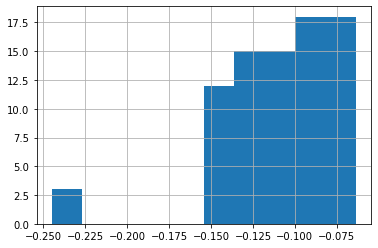

In [44]:
odds['corr'].hist();

In [45]:
prob_hilo = []

for r in list(zip(odds['alpha_1'], odds['alpha_2'], odds['mu_1'], odds['mu_2'], odds['omega'], odds['CHL_LINE'])):
    total_count = 1. / torch.tensor(r[0:2], device='cpu') 
    logits = torch.log(torch.tensor(r[0:2], device='cpu') * torch.tensor(r[2:4], device='cpu'))
    omega = torch.tensor(r[4], device='cpu')

    bnb_corner = BivariateNegativeBinomialSL(total_count=total_count, omega=omega, logits=logits)
    value = torch.cartesian_prod(torch.arange(0., 15.), torch.arange(0., 15.))
    corner = bnb_corner.log_prob(value).exp()
    
    line = r[5]
    mask = value.sum(-1) < line
    prob_lo = corner[mask].sum()
    prob_hi = 1 - prob_lo
    
    prob_hilo.append([prob_hi.item(), prob_lo.item()])

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


In [46]:
odds[['prob_hi', 'prob_lo']] = prob_hilo

In [47]:
odds['kelly_hi'] = (odds['prob_hi'] * odds['CHL_H'] - 1) / (odds['CHL_H'] - 1)
odds['kelly_lo'] = (odds['prob_lo'] * odds['CHL_L'] - 1) / (odds['CHL_L'] - 1)

In [48]:
odds['kelly'] = np.where(
    np.maximum(odds['kelly_hi'], odds['kelly_lo']) > 0, 
    np.where(odds['kelly_hi'] > odds['kelly_lo'], odds['kelly_hi'], odds['kelly_lo']), 
    np.nan
)

In [49]:
odds['bet'] = np.where(
    np.maximum(odds['kelly_hi'], odds['kelly_lo']) > 0, 
    np.where(odds['kelly_hi'] > odds['kelly_lo'], 'High', 'Low'), 
    None
)

In [50]:
odds = odds.sort_values('kelly', ascending=False).reset_index(drop=True)

In [51]:
odds['selected'] = np.where(
    odds['MAINLINE']==True, np.where(
        odds['kelly']>0.3, '$$$', np.where(
            odds['kelly']>0.2, '$$', np.where(
                odds['kelly']>0.1, '$', None))), 
    None
)

In [52]:
odds = odds.drop(columns=cols_pred+['kelly_hi', 'kelly_lo'])

In [53]:
odds[odds.bet.notna() & odds.selected.notna()]

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,prob_hi,prob_lo,kelly,bet,selected
2,SUN30,2021-11-21,22:00:00,Eng Premier [EPL],Manchester City,Everton,True,11.5,2.15,1.62,0.260256,0.739744,0.319975,Low,$$$
3,SUN58,2021-11-22,01:30:00,Spanish Division 1 [SFL],CF Elche,Betis,True,8.5,1.78,1.92,0.661299,0.338701,0.227068,High,$$
5,SUN19,2021-11-21,20:00:00,French Division 1 [FFL],Brest,Lens,True,9.5,1.82,1.88,0.621038,0.378962,0.158888,High,$
6,SUN65,2021-11-22,03:45:00,French Division 1 [FFL],Lyon,Marseille,True,9.5,1.80,1.90,0.623976,0.376024,0.153947,High,$
9,SUN22,2021-11-21,20:30:00,German Division 2 [GD2],Heidenheim,Holstein Kiel,True,10.5,1.95,1.75,0.569307,0.430693,0.115946,High,$
10,SUN64,2021-11-22,03:45:00,Italian Division 1 [ISA],Genoa,Roma,True,10.5,2.20,1.59,0.332005,0.667995,0.105274,Low,$


In [54]:
display_df(odds[odds.MatchDay.isin(odds[odds.bet.notna() & odds.selected.notna()].MatchDay) & odds.bet.notna()])

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,prob_hi,prob_lo,kelly,bet,selected
0,SUN30,2021-11-21,22:00:00,Eng Premier [EPL],Manchester City,Everton,False,14.5,4.40,1.16,0.076305,0.923695,0.446792,Low,None
1,SUN30,2021-11-21,22:00:00,Eng Premier [EPL],Manchester City,Everton,False,12.5,2.75,1.39,0.180529,0.819471,0.356576,Low,None
2,SUN30,2021-11-21,22:00:00,Eng Premier [EPL],Manchester City,Everton,True,11.5,2.15,1.62,0.260256,0.739744,0.319975,Low,$$$
3,SUN58,2021-11-22,01:30:00,Spanish Division 1 [SFL],CF Elche,Betis,True,8.5,1.78,1.92,0.661299,0.338701,0.227068,High,$$
4,SUN58,2021-11-22,01:30:00,Spanish Division 1 [SFL],CF Elche,Betis,False,9.5,2.29,1.55,0.547921,0.452079,0.197472,High,None
5,SUN19,2021-11-21,20:00:00,French Division 1 [FFL],Brest,Lens,True,9.5,1.82,1.88,0.621038,0.378962,0.158888,High,$
6,SUN65,2021-11-22,03:45:00,French Division 1 [FFL],Lyon,Marseille,True,9.5,1.80,1.90,0.623976,0.376024,0.153947,High,$
7,SUN19,2021-11-21,20:00:00,French Division 1 [FFL],Brest,Lens,False,10.5,2.30,1.54,0.512781,0.487219,0.137996,High,None
8,SUN65,2021-11-22,03:45:00,French Division 1 [FFL],Lyon,Marseille,False,10.5,2.25,1.57,0.515244,0.484756,0.127440,High,None
9,SUN22,2021-11-21,20:30:00,German Division 2 [GD2],Heidenheim,Holstein Kiel,True,10.5,1.95,1.75,0.569307,0.430693,0.115946,High,$


In [55]:
odds.to_csv(path_output/f'odds-{datetime.now().strftime("%Y-%m-%d")}.csv', float_format='%.2f', index=False)